# Training and Validating a Machine Learning Model

Linear regression is the most commonly employed machine learning model since it is highly interpretable and well studied.  This is often the first pass for data scientists modeling continuous variables.  This notebook trains a multivariate regression model and interprets the results. This notebook is organized in two sections:

- Exercise 1: Training a Model
- Exercise 2: Validating a Model

Run the following cell to load common libraries.

In [0]:
import urllib.request
import os
import numpy as np
from pyspark.sql.types import * 
from pyspark.sql.functions import col, lit
from pyspark.sql.functions import udf
import matplotlib
import matplotlib.pyplot as plt
print("Imported common libraries.")

Imported common libraries.

## Load the training data

In this notebook, we will be using a subset of NYC Taxi & Limousine Commission - green taxi trip records available from [Azure Open Datasets]( https://azure.microsoft.com/en-us/services/open-datasets/). The data is enriched with holiday and weather data. Each row of the table represents a taxi ride that includes columns such as number of passengers, trip distance, datetime information, holiday and weather information, and the taxi fare for the trip.

Run the following cell to load the table into a Spark dataframe and reivew the dataframe.

In [0]:
dataset = spark.sql("select * from nyc_taxi")
display(dataset)

passengerCount,tripDistance,hour_of_day,day_of_week,month_num,normalizeHolidayName,isPaidTimeOff,snowDepth,precipTime,precipDepth,temperature,totalAmount
1,9.4,15,2,1,None,false,29.058823529411764,24.0,3.0,6.18571428571429,44.3
null,14.75,13,4,1,None,false,0.0,6.0,0.0,4.571929824561403,44.8
1,3.35,23,4,1,None,false,0.0,1.0,0.0,4.384090909090913,18.96
1,3.33,18,2,1,None,false,29.058823529411764,24.0,3.0,6.18571428571429,16.3
1,0.47,17,6,1,None,false,0.0,1.0,0.0,3.846428571428569,5.3
1,3.07,9,1,1,None,false,0.0,6.0,0.0,0.1594594594594597,16.3
1,0.92,23,4,1,None,false,0.0,1.0,0.0,-2.999107142857142,8.97
1,1.9,12,4,1,None,false,0.0,1.0,0.0,4.384090909090913,11.8
1,0.77,0,1,1,None,false,0.0,1.0,0.0,-5.393749999999998,7.3
null,2.35,2,6,1,None,false,0.0,24.0,254.0,10.943654822335034,14.16


## Exercise 1: Training a Model

In this section we will use the Spark's machine learning library, `MLlib` to train a `NYC Taxi Fare Predictor` machine learning model. We will train a multivariate regression model to predict taxi fares in New York City based on input features such as, number of passengers, trip distance, datetime, holiday information and weather information. Before we start, let's review the three main abstractions that are provided in the `MLlib`:<br><br>

1. A **transformer** takes a DataFrame as an input and returns a new DataFrame with one or more columns appended to it.  
  - Transformers implement a `.transform()` method.  
2. An **estimator** takes a DataFrame as an input and returns a model, which itself is a transformer.
  - Estimators implements a `.fit()` method.
3. A **pipeline** combines together transformers and estimators to make it easier to combine multiple algorithms.
  - Pipelines implement a `.fit()` method.
  
These basic building blocks form the machine learning process in Spark from featurization through model training and deployment.

-sandbox

### Featurization of the training data

Machine learning models are only as strong as the data they see and can only work on numerical data.  **Featurization is the process of creating this input data for a model.** In this section we will build derived features and create a pipeline of featurization steps.

Run the following cell to engineer the cyclical features to represent `hour_of_day`. Also, we will drop rows with null values in the `totalAmount` column and convert the column ` isPaidTimeOff ` as integer type.

In [0]:
def get_sin_cosine(value, max_value):
  sine =  np.sin(value * (2.*np.pi/max_value))
  cosine = np.cos(value * (2.*np.pi/max_value))
  return (sine.tolist(), cosine.tolist())

schema = StructType([
    StructField("sine", DoubleType(), False),
    StructField("cosine", DoubleType(), False)
])

get_sin_cosineUDF = udf(get_sin_cosine, schema)

dataset = dataset.withColumn("udfResult", get_sin_cosineUDF(col("hour_of_day"), lit(24))).withColumn("hour_sine", col("udfResult.sine")).withColumn("hour_cosine", col("udfResult.cosine")).drop("udfResult").drop("hour_of_day")

dataset = dataset.filter(dataset.totalAmount.isNotNull())

dataset = dataset.withColumn("isPaidTimeOff", col("isPaidTimeOff").cast("integer"))

display(dataset)

passengerCount,tripDistance,day_of_week,month_num,normalizeHolidayName,isPaidTimeOff,snowDepth,precipTime,precipDepth,temperature,totalAmount,hour_sine,hour_cosine
1,9.4,2,1,None,0,29.058823529411764,24.0,3.0,6.18571428571429,44.3,-0.7071067811865471,-0.7071067811865479
null,14.75,4,1,None,0,0.0,6.0,0.0,4.571929824561403,44.8,-0.25881904510252035,-0.9659258262890684
1,3.35,4,1,None,0,0.0,1.0,0.0,4.384090909090913,18.96,-0.25881904510252157,0.9659258262890681
1,3.33,2,1,None,0,29.058823529411764,24.0,3.0,6.18571428571429,16.3,-1.0,-1.8369701987210297E-16
1,0.47,6,1,None,0,0.0,1.0,0.0,3.846428571428569,5.3,-0.9659258262890681,-0.2588190451025215
1,3.07,1,1,None,0,0.0,6.0,0.0,0.1594594594594597,16.3,0.7071067811865476,-0.7071067811865475
1,0.92,4,1,None,0,0.0,1.0,0.0,-2.999107142857142,8.97,-0.25881904510252157,0.9659258262890681
1,1.9,4,1,None,0,0.0,1.0,0.0,4.384090909090913,11.8,1.2246467991473532E-16,-1.0
1,0.77,1,1,None,0,0.0,1.0,0.0,-5.393749999999998,7.3,0.0,1.0
null,2.35,6,1,None,0,0.0,24.0,254.0,10.943654822335034,14.16,0.49999999999999994,0.8660254037844387


Run the following cell to create stages in our featurization pipeline to scale the numerical features and to encode the categorical features.

In [0]:
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

numerical_cols = ["passengerCount", "tripDistance", "snowDepth", "precipTime", "precipDepth", "temperature", "hour_sine", "hour_cosine"]
categorical_cols = ["day_of_week", "month_num", "normalizeHolidayName", "isPaidTimeOff"]
label_column = "totalAmount"

stages = []

inputCols = ["passengerCount"]
outputCols = ["passengerCount"]
imputer = Imputer(strategy="median", inputCols=inputCols, outputCols=outputCols)
stages += [imputer]

assembler = VectorAssembler().setInputCols(numerical_cols).setOutputCol('numerical_features')
scaler = MinMaxScaler(inputCol=assembler.getOutputCol(), outputCol="scaled_numerical_features")
stages += [assembler, scaler]

for categorical_col in categorical_cols:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categorical_col, outputCol=categorical_col + "_index", handleInvalid="skip")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categorical_col + "_classVector"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]
    
print("Created stages in our featurization pipeline to scale the numerical features and to encode the categorical features.")

Created stages in our featurization pipeline to scale the numerical features and to encode the categorical features.

Use a `VectorAssembler` to combine all the feature columns into a single vector column named **features**.

In [0]:
assemblerInputs = [c + "_classVector" for c in categorical_cols] + ["scaled_numerical_features"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
print("Used a VectorAssembler to combine all the feature columns into a single vector column named features.")

Used a VectorAssembler to combine all the feature columns into a single vector column named features.

-sandbox
**Run the stages as a Pipeline**

The pipeline is itself is now an `estimator`.  Call the pipeline's `fit` method and then `transform` the original dataset. This puts the data through all of the feature transformations we described in a single call. Observe the new columns, especially column: **features**.

In [0]:
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(dataset)
preppedDataDF = pipelineModel.transform(dataset)

display(preppedDataDF)

passengerCount,tripDistance,day_of_week,month_num,normalizeHolidayName,isPaidTimeOff,snowDepth,precipTime,precipDepth,temperature,totalAmount,hour_sine,hour_cosine,numerical_features,scaled_numerical_features,day_of_week_index,day_of_week_classVector,month_num_index,month_num_classVector,normalizeHolidayName_index,normalizeHolidayName_classVector,isPaidTimeOff_index,isPaidTimeOff_classVector,features
1,9.4,2,1,None,0,29.058823529411764,24.0,3.0,6.18571428571429,44.3,-0.7071067811865471,-0.7071067811865479,"Map(vectorType -> dense, length -> 8, values -> List(1.0, 9.4, 29.058823529411764, 24.0, 3.0, 6.18571428571429, -0.7071067811865471, -0.7071067811865479))","Map(vectorType -> dense, length -> 8, values -> List(0.0, 0.1501439078989447, 0.433126095966842, 1.0, 3.0003000300030005E-4, 0.49031146513917523, 0.14644660940672644, 0.14644660940672605))",4.0,"Map(vectorType -> sparse, length -> 6, indices -> List(4), values -> List(1.0))",3.0,"Map(vectorType -> sparse, length -> 5, indices -> List(3), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 24, indices -> List(4, 9, 11, 15, 17, 18, 19, 20, 21, 22, 23), values -> List(1.0, 1.0, 1.0, 1.0, 0.1501439078989447, 0.433126095966842, 1.0, 3.0003000300030005E-4, 0.49031146513917523, 0.14644660940672644, 0.14644660940672605))"
1,14.75,4,1,None,0,0.0,6.0,0.0,4.571929824561403,44.8,-0.25881904510252035,-0.9659258262890684,"Map(vectorType -> dense, length -> 8, values -> List(1.0, 14.75, 0.0, 6.0, 0.0, 4.571929824561403, -0.25881904510252035, -0.9659258262890684))","Map(vectorType -> dense, length -> 8, values -> List(0.0, 0.23568915893827952, 0.0, 0.21739130434782608, 0.0, 0.4498693592479367, 0.37059047744873985, 0.01703708685546579))",0.0,"Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0))",3.0,"Map(vectorType -> sparse, length -> 5, indices -> List(3), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 24, indices -> List(0, 9, 11, 15, 17, 19, 21, 22, 23), values -> List(1.0, 1.0, 1.0, 1.0, 0.23568915893827952, 0.21739130434782608, 0.4498693592479367, 0.37059047744873985, 0.01703708685546579))"
1,3.35,4,1,None,0,0.0,1.0,0.0,4.384090909090913,18.96,-0.25881904510252157,0.9659258262890681,"Map(vectorType -> dense, length -> 8, values -> List(1.0, 3.35, 0.0, 1.0, 0.0, 4.384090909090913, -0.25881904510252157, 0.9659258262890681))","Map(vectorType -> sparse, length -> 8, indices -> List(1, 5, 6, 7), values -> List(0.05340582027502399, 0.44516203835545143, 0.3705904774487392, 0.9829629131445341))",0.0,"Map(vectorType -> sparse, length -> 6, indices -> List(0), values -> List(1.0))",3.0,"Map(vectorType -> sparse, length -> 5, indices -> List(3), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 24, indices -> List(0, 9, 11, 15, 17, 21, 22, 23), values -> List(1.0, 1.0, 1.0, 1.0, 0.05340582027502399, 0.44516203835545143, 0.3705904774487392, 0.9829629131445341))"
1,3.33,2,1,None,0,29.058823529411764,24.0,3.0,6.18571428571429,16.3,-1.0,-1.8369701987210297E-16,"Map(vectorType -> dense, length -> 8, values -> List(1.0, 3.33, 29.058823529411764, 24.0, 3.0, 6.18571428571429, -1.0, -1.8369701987210297E-16))","Map(vectorType -> dense, length -> 8, values -> List(0.0, 0.053086024944035824, 0.433126095966842, 1.0, 3.0003000300030005E-4, 0.49031146513917523, 0.0, 0.4999999999999999))",4.0,"Map(vectorType -> sparse, length -> 6, indices -> List(4), values -> List(1.0))",3.0,"Map(vectorType -> sparse, length -> 5, indices -> List(3), values -> Li

-sandbox

### Train a multivariate regression model

A multivariate regression takes an arbitrary number of input features. The equation for multivariate regression looks like the following where each feature `p` has its own coefficient:

&nbsp;&nbsp;&nbsp;&nbsp;`Y ≈ β<sub>0</sub> + β<sub>1</sub>X<sub>1</sub> + β<sub>2</sub>X<sub>2</sub> + ... + β<sub>p</sub>X<sub>p</sub>`

Split the featurized training data for training and validating the model

In [0]:
(trainingData, testData) = preppedDataDF.randomSplit([0.7, 0.3], seed=97)
print("The training data is split for training and validating the model: 70-30 split.")

The training data is split for training and validating the model: 70-30 split.

Create the estimator `LinearRegression` and call its `fit` method to get back the trained ML model (`lrModel`). You can read more about [Linear Regression] from the [classification and regression] section of MLlib Programming Guide.

[classification and regression]: https://spark.apache.org/docs/latest/ml-classification-regression.html
[Linear Regression]: https://spark.apache.org/docs/3.1.1/ml-classification-regression.html#linear-regression

In [0]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol=label_column)

lrModel = lr.fit(trainingData)

print(lrModel)

LinearRegressionModel: uid=LinearRegression_206161c2b857, numFeatures=24

## Exercise 2: Validating a Model

-sandbox

From the trained model summary, let’s review some of the model performance metrics such as, Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R<sup>2</sup> score. We will also look at the multivariate model’s coefficients.

In [0]:
summary = lrModel.summary
print("RMSE score: {} \nMAE score: {} \nR2 score: {}".format(summary.rootMeanSquaredError, summary.meanAbsoluteError, lrModel.summary.r2))
print("")
print("β0 (intercept): {}".format(lrModel.intercept))
i = 0
for coef in lrModel.coefficients:
  i += 1
  print("β{} (coefficient): {}".format(i, coef))

RMSE score: 4.083166417623794 
MAE score: 2.161283918878106 
R2 score: 0.8583561705739742

β0 (intercept): 5.546846200787039
β1 (coefficient): 0.4082726335494935
β2 (coefficient): -0.3203472582145028
β3 (coefficient): -0.629935834971372
β4 (coefficient): 0.294788804509589
β5 (coefficient): 0.24112497254624887
β6 (coefficient): 0.3414059599852025
β7 (coefficient): -0.1026683618368603
β8 (coefficient): -0.08985172261425202
β9 (coefficient): -0.14499756031599267
β10 (coefficient): 0.09756576364493555
β11 (coefficient): -0.1008911290304535
β12 (coefficient): 0.41019782882789596
β13 (coefficient): -0.6559163926967875
β14 (coefficient): -1.4378172538146037
β15 (coefficient): -2.051295275675274
β16 (coefficient): -0.7013543448783203
β17 (coefficient): 0.25292335204718075
β18 (coefficient): 216.9094560052516
β19 (coefficient): 0.10502338757717544
β20 (coefficient): 0.15187161425122367
β21 (coefficient): -0.8702812506480657
β22 (coefficient): 0.6009422238228578
β23 (coefficient): -0.9347536971230438
β24 (coefficient): -1.0087880313492685

-sandbox

Evaluate the model performance using the hold-back  dataset. Observe that the RMSE and R<sup>2</sup> score on holdback dataset is slightly degraded compared to the training summary. A big disparity in performance metrics between training and hold-back dataset can be an indication of model overfitting the training data.

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = lrModel.transform(testData)
evaluator = RegressionEvaluator(
    labelCol=label_column, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
evaluator = RegressionEvaluator(
    labelCol=label_column, predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("MAE on test data = %g" % mae)
evaluator = RegressionEvaluator(
    labelCol=label_column, predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R2 on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data = 5.18444
MAE on test data = 2.15868
R2 on test data = 0.786968

**Compare the summary statistics between the true values and the model predictions**

In [0]:
display(predictions.select(["totalAmount",  "prediction"]).describe())

summary,totalAmount,prediction
count,3480,3480
mean,14.897370689655352,14.819030458137803
stddev,11.234197496969816,9.996372227102915
min,3.3,3.757438171954438
max,200.0,102.49455247238514


**Visualize the plot between true values and the model predictions**

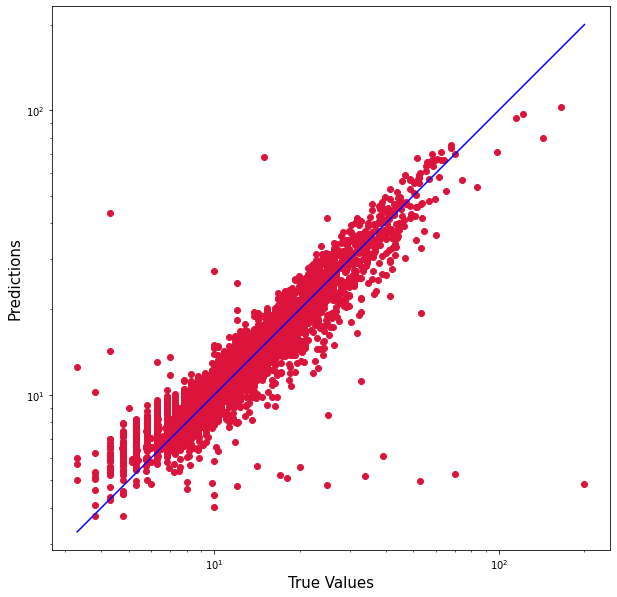

In [0]:
p_df = predictions.select(["totalAmount",  "prediction"]).toPandas()
true_value = p_df.totalAmount
predicted_value = p_df.prediction

plt.figure(figsize=(10,10))
plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()